In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = "/home/clairegayral/Documents/openclassroom/data/"

## my .py : 
import read_csv
import preprocess
import list_from_data_field 
import missing_values_treatment

My preprocess consisted in : 
* Read the data : I only kept data with the "nutrition score" for this analyse,
* Drop the columns with too many missing values
* Select the variables that will interest me : the nutrition variable, with name of the product, its code reference, country of sell, and name of the person that inter it in the open food fact base.
* Merge the two columns that are about the palm oil ingredients.
* Remove outliers (from the semantic of columns, and compared to the other values)

Mon prétraitement consistait en : 
* Lecture des données : Je n'ai gardé que les données avec le "score nutritionnel" pour cette analyse,
* Suppression des colonnes avec trop de valeurs manquantes
* Sélection des variables d'intérêt : la variable nutritionnelle, avec le nom du produit, sa référence de code, le pays de vente, et le nom de la personne qui l'a introduit dans la base de données 'open food facts'.
* Fusion des deux colonnes qui concernent les ingrédients de l'huile de palme.
* Fusion des doublons (par nom de produit)
* Suppression les valeurs aberrantes (de la sémantique des colonnes, et par rapport aux autres valeurs).


In [2]:
##
## read data : 
##
# read_csv.save_csv()
df_original = pd.read_csv(data_path+"projet2/df_original.csv", 
                          low_memory=False, index_col=0)

df = df_original.copy()

##
## select variables 
##
list_of_nutri_facts = list_from_data_field.list_of_nutri_facts
interest_var = pd.Index(["code","product_name","creator","countries",
                         "additives_n","ingredients_from_palm_oil"])
interest_var = interest_var.append(df.columns.intersection(list_of_nutri_facts))
df = preprocess.select_columns(df, interest_var)


##
## set dtype : 
##
df = preprocess.set_dtypes(df)

##
## merge "from palm oil" 
##
df = preprocess.merge_palm_oil_cols(df)

##
## drop empty columns
##
nan_repartition = df_original.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.75)
df = preprocess.preprocess_drop_col_nan(df_original, nan_threshold)


In [3]:
float_var = list_from_data_field.list_of_nutri_facts
float_var += ["additives_n", "ingredients_from_palm_oil","ingredients_from_palm_oil_n"]
float_var = df.columns.intersection(float_var).values

##############################################################################
####### to put on the python script #######################
from sklearn.metrics.pairwise import nan_euclidean_distances
from sklearn import preprocessing

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

def get_index_merge_duplicates(data, float_var, threshold_clustering = 1.15):
    ## return a dict of indexes to merge, with key = product_name + cluster
    
    ## std var by var :
    data_float = data[float_var].copy()
    data_float.at[:,:] = preprocessing.StandardScaler().fit_transform(data_float)

    res = {}

    products = data["product_name"].drop_duplicates()
    for prod_name in products : 
        x = data[data.product_name == prod_name]
        prod_index =  x.index

        ## if there is more than one product with the same name 
        if len(prod_index) > 1 : 
            prod_values = data_float.loc[prod_index,:]
            prod_dist = pd.DataFrame(nan_euclidean_distances(prod_values),
                                  columns=prod_index, index = prod_index)
            Z = linkage(prod_dist, "weighted")
            prod_clustering = pd.Series(fcluster(Z, t=threshold_clustering), index = prod_index)
            for k in np.unique(prod_clustering.values):
                index_merge = prod_clustering[prod_clustering==k].index
                res[prod_name+str(k)]= index_merge
    return(res)
##############################################################################

To drop duplicates, I compute a hierarchical clustering on the euclidean distance matrix of products with the same name, and I saved the indexes to gather in a dictionnary : 

```python
## 
## Example of duplicate treatment for one product : 
##

# prod_name = "Salade de carottes râpées"
prod_name = "Abondance"
res = {}

x = data[data.product_name == prod_name]
prod_index = x.index
## if there is more than one product with the same name 
if len(prod_index) > 1 : 
    prod_values = data_float.loc[prod_index,:]
    prod_dist = pd.DataFrame(nan_euclidean_distances(prod_values),
                          columns=prod_index, index = prod_index)
    Z = linkage(prod_dist, "weighted")
    prod_clustering = pd.Series(fcluster(Z, t=1.15), index = prod_index)
    for k in np.unique(prod_clustering.values):
        index_merge = prod_clustering[prod_clustering==k].index
        res[prod_name+str(k)]= index_merge

```

In [20]:
data = df.copy()
# res = get_index_merge_duplicates(data, float_var, 1.15)
# import pickle
# with open(data_path +'index_to_merge_duplicates.pkl', 'wb') as fp:
#     pickle.dump(res, fp, pickle.HIGHEST_PROTOCOL)
with open(data_path +'index_to_merge_duplicates.pkl', 'rb') as f:
    res = pickle.load(f)

In [15]:
res2 = res

In [19]:
res3

{'Salade de carottes râpées1': Int64Index([15, 787420, 883090], dtype='int64'),
 'Tarte noix de coco1': Int64Index([24, 2344], dtype='int64'),
 'Compote de poire1': Int64Index([34, 2325, 776061, 937070], dtype='int64'),
 'Abondance1': Int64Index([567199, 615627], dtype='int64'),
 'Abondance2': Int64Index([    63, 278958, 300330, 309514, 485882, 512583, 525197, 525198,
             526063, 527675, 570443, 605715, 605717, 605718, 605720, 605721,
             605723, 605724, 605725, 605726, 605729, 605730, 605731, 605733,
             605735, 605739, 605741, 605743, 788153, 790311],
            dtype='int64'),
 'Abondance3': Int64Index([533164, 533166, 568173, 691081], dtype='int64'),
 'Abondance4': Int64Index([523563, 523564, 523566, 523568], dtype='int64'),
 'Abondance5': Int64Index([573054, 573120, 573121, 573122, 573128, 884208], dtype='int64'),
 'Abondance6': Int64Index([605722], dtype='int64'),
 'Abondance7': Int64Index([605727], dtype='int64'),
 'Bagel1': Int64Index([     66,  1607

In [17]:
## 
## Example of duplicate treatment for one product : 
##

# prod_name = "Salade de carottes râpées"
prod_name = "Abondance"
res = {}

x = data[data.product_name == prod_name]
prod_index = x.index
## if there is more than one product with the same name 
if len(prod_index) > 1 : 
    prod_values = data_float.loc[prod_index,:]
    prod_dist = pd.DataFrame(nan_euclidean_distances(prod_values),
                          columns=prod_index, index = prod_index)
    Z = linkage(prod_dist, "weighted")
    prod_clustering = pd.Series(fcluster(Z, t=1.15), index = prod_index)
    for k in np.unique(prod_clustering.values):
        index_merge = prod_clustering[prod_clustering==k].index
        res[prod_name+str(k)]= index_merge


In [20]:
for index in res.values():
    

dict_values([Int64Index([567199, 615627], dtype='int64'), Int64Index([    63, 278958, 300330, 309514, 485882, 512583, 525197, 525198,
            526063, 527675, 570443, 605715, 605717, 605718, 605720, 605721,
            605723, 605724, 605725, 605726, 605729, 605730, 605731, 605733,
            605735, 605739, 605741, 605743, 788153, 790311],
           dtype='int64'), Int64Index([533164, 533166, 568173, 691081], dtype='int64'), Int64Index([523563, 523564, 523566, 523568], dtype='int64'), Int64Index([573054, 573120, 573121, 573122, 573128, 884208], dtype='int64'), Int64Index([605722], dtype='int64'), Int64Index([605727], dtype='int64')])

In [15]:
# prod_values.groupby(clustering)

# for k in np.unique(prod_clustering.values): 
k = 2
index_merge = prod_clustering[prod_clustering==k].index
# dict_index_to_merge_by_product_name = {}
res = {}
res[prod_name+str(k)]= index_merge
res

{'Abondance2': Int64Index([    63, 278958, 300330, 309514, 485882, 512583, 525197, 525198,
             526063, 527675, 570443, 605715, 605717, 605718, 605720, 605721,
             605723, 605724, 605725, 605726, 605729, 605730, 605731, 605733,
             605735, 605739, 605741, 605743, 788153, 790311],
            dtype='int64')}

In [ ]:

prod_values_k = data.loc[index_merge,float_var]
## if there are products to merge :
# if len(index_merge)>1 :
#     print("toto")

res = pd.Series(data.loc[index_merge].drop_duplicates().values[0], 
                index=data.columns)
# res.at[float_var] = prod_values_k
#     res[p_var_index] = product_values.fillna(method="bfill",

prod_values_k

In [12]:
# res[prod_values_k.columns.values] = prod_values_k.mean(skipna=True).values
# res[float_var]
prod_values_k.loc[:,~prod_values_k.mean(skipna=True).isna()].mean(skipna=True)

additives_n                       0.000000
ingredients_from_palm_oil_n       0.000000
energy-kcal_100g                396.233333
energy_100g                    1657.766667
fat_100g                         32.286667
saturated-fat_100g               21.066667
carbohydrates_100g                0.680000
sugars_100g                       0.356667
proteins_100g                    25.143333
sodium_100g                       0.590000
nutrition-score-fr_100g          15.000000
dtype: float64

In [444]:
nb_prod_in_k = prod_values_k.shape[0]
prod_values_k.loc[:,prod_values_k.isna().sum()<nb_prod_in_k].shape#mean(skipna = True)

(30, 11)

In [436]:
prod_values_k.mean()

additives_n                       0.000000
ingredients_from_palm_oil_n       0.000000
energy-kj_100g                         NaN
energy-kcal_100g                396.233333
energy_100g                    1657.766667
fat_100g                         32.286667
saturated-fat_100g               21.066667
monounsaturated-fat_100g               NaN
polyunsaturated-fat_100g               NaN
omega-3-fat_100g                       NaN
omega-6-fat_100g                       NaN
omega-9-fat_100g                       NaN
trans-fat_100g                         NaN
cholesterol_100g                       NaN
carbohydrates_100g                0.680000
sugars_100g                       0.356667
starch_100g                            NaN
polyols_100g                           NaN
fiber_100g                             NaN
proteins_100g                    25.143333
sodium_100g                       0.590000
alcohol_100g                           NaN
vitamin-a_100g                         NaN
vitamin-d_1

In [408]:
# res[res[float_var].isna()].columns
res[float_var][~res[float_var].isna()].index

Index(['additives_n', 'ingredients_from_palm_oil_n', 'energy-kcal_100g',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'proteins_100g', 'sodium_100g',
       'nutrition-score-fr_100g'],
      dtype='object')

In [404]:
res

code                                                                           2449915026831
url                                        http://world-en.openfoodfacts.org/product/2449...
creator                                                                              kiliweb
created_t                                                                         1587060402
created_datetime                                                        2020-04-16T18:06:42Z
                                                                 ...                        
cocoa_100g                                                                               NaN
carbon-footprint_100g                                                                    NaN
carbon-footprint-from-meat-or-fish_100g                                                  NaN
nutrition-score-fr_100g                                                                 15.0
phylloquinone_100g                                                    

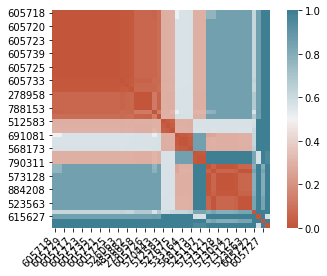

In [258]:
import seaborn as sns
# index_sort = prod_dist[prod_dist.sum()==prod_dist.sum().min()].index[0]
index_sort = prod_dist.sum().sort_values().index.values
tmp = prod_dist.loc[index_sort,index_sort]
ax = sns.heatmap(
#     (prod_dist>1).sort_values(by = index_sort).sort_values(by = index_sort, axis = 1),
    tmp,
    vmin=0, vmax=1, center=0.5,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
plt.show()

In [172]:
for i in range(len(prod_index)):
    for j in range(len(prod_index)-i):
        print(i,j)

0 0
0 1
0 2
1 0
1 1
2 0


In [183]:
for k in range(tmp[0].shape[0]):
    i = tmp[0][k]
    j = tmp[1][k]
    print(i,j)

0 2
1 2
2 0
2 1


In [201]:
# bool_sdp_matrix = prod_dist<1
# tmp = np.where(bool_sdp_matrix)
# for k in range(tmp[0].shape[0]):
#     i = tmp[0][k]
#     j = tmp[1][k]
#     if i>j :
#         print(i,j)

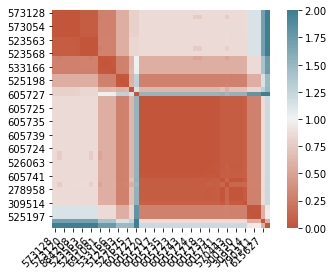

In [211]:
import seaborn as sns
ax = sns.heatmap(
    prod_dist.sort_values(by = prod_index[-1]).sort_values(by = prod_index[-1], axis = 1),
    vmin=0, vmax=2, center=1,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
plt.show()

In [90]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

products = data["product_name"].drop_duplicates()
product = products.iloc[1]

x = data[data.product_name == product]
product_index =  x.index

if len(product_index) > 1 : 
    p_float_var = (x.notna().sum()>=1).index.intersection(float_var)
    p_var_index = x[p_float_var].columns
    product_values = x.loc[:,p_float_var]

    p_dist = nan_euclidean_distances(product_values)
    print5

In [49]:
nan_euclidean_distances(product_values)

array([[  0.        , 527.48694793, 461.54388638],
       [527.48694793,   0.        ,  74.56698992],
       [461.54388638,  74.56698992,   0.        ]])

In [31]:
x.columns.shape

(65,)

In [41]:
x.drop_duplicates(subset="product_name").values[0]

array(['0000000000949', 'kiliweb', 'Salade de carottes râpées', 'France',
       nan, nan, nan, 32.0, 134.0, 0.3, 0.1, nan, nan, nan, nan, nan, nan,
       nan, 5.3, 3.9, nan, nan, nan, 0.9, nan, nan, nan, 0.168, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, 1.0, nan], dtype=object)

In [ ]:

#     res = pd.Series(x.drop_duplicates(subset="product_name").values[0], index=x.columns)
#     res[p_var_index] = product_values.fillna(method="bfill",
#                             axis=0).fillna(method="ffill",axis=0).mean().values
    
    

In [ ]:
p_float_var = (x.notna().sum()>=1).index.intersection(float_var)

res = x.drop_duplicates(subset="product_name")
res[p_float_var] = product_values.fillna(method="bfill",axis=0).fillna(method="ffill",axis=0).mean()
# print(res[p_float_var])

In [82]:
data.loc[:,float_var]

,additives_n,ingredients_from_palm_oil_n,energy-kj_100g,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,...,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,carbon-footprint_100g,nutrition-score-fr_100g
4,-0.711746,-0.139854,-0.053007,NaN,-0.015797,-0.006382,-0.001500,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.990612
15,NaN,NaN,NaN,-0.061308,-0.062512,-0.012700,-0.001668,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.919729
24,NaN,NaN,NaN,0.021267,0.022530,0.004653,-0.000432,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.541120
34,NaN,NaN,NaN,-0.031733,-0.032048,-0.012940,-0.001676,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.256848
38,NaN,NaN,NaN,-0.035045,-0.035485,-0.002784,-0.001596,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.919729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716261,NaN,NaN,NaN,0.012986,0.014026,0.008651,-0.000311,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.878239
1716263,NaN,NaN,NaN,0.014169,0.015249,-0.012540,-0.001676,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.032102
1716267,NaN,NaN,NaN,0.009910,0.010822,0.003214,-0.001195,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.653493
1716269,-0.052882,-0.139854,-0.056121,NaN,-0.016438,-0.006862,-0.001291,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.316374


In [ ]:
data.iloc[(data[float_var].isna().sum(axis=0)==0)]

In [ ]:
tmp = df.groupby('product_name').fillna(method='ffill').\
                             fillna(method='bfill').\
                             drop_duplicates()
                     


In [74]:
data[float_var].isna().sum(axis=0)==0

additives_n                    False
ingredients_from_palm_oil      False
energy-kj_100g                 False
energy-kcal_100g               False
energy_100g                    False
                               ...  
ph_100g                        False
fruits-vegetables-nuts_100g    False
carbon-footprint_100g          False
nutrition-score-fr_100g         True
nutrition-score-uk_100g        False
Length: 61, dtype: bool

In [ ]:
float_var = list_from_data_field.list_of_nutri_facts
float_var += ["additives_n", "ingredients_from_palm_oil","ingredients_from_palm_oil_n"]
float_var = df.columns.intersection(float_var).values

product = products.iloc[1]
product_index =  data[data.product_name == product].index
if len(product_index) > 1 : 
    product_values = data.loc[product_index,(data.loc[product_index].notna().sum()>=1)]
#     meth 1 
    product_mean = product_values[product_values.columns.intersection(float_var)].mean()
    product_std = product_values[product_values.columns.intersection(float_var)].std()
    to_merge = ((product_mean - product_std) - product_values < 0) | (product_values - (product_mean - product_std) < 0)
    # to_merge.sum().sum()/to_merge.shape[1]
    product_diff = product_values[product_values.columns.intersection(float_var)].diff()#.iloc[1:]
    print(abs(product_diff/product_values.mean()).mean().mean())

In [ ]:
float_var = list_from_data_field.list_of_nutri_facts
float_var += ["additives_n", "ingredients_from_palm_oil","ingredients_from_palm_oil_n"]
float_var = df.columns.intersection(float_var).values

data = df.copy()
products = data["product_name"].drop_duplicates()
for product in products : 
    product_index =  data[data.product_name == product].index
    if len(product_index) > 1 : 
        product_values = data.loc[product_index,(data.loc[product_index].notna().sum()>=1)]
    #     meth 1 
        product_mean = product_values[product_values.columns.intersection(float_var)].mean()
        product_std = product_values[product_values.columns.intersection(float_var)].std()
        to_merge = ((product_mean - product_std) - product_values < 0) | (product_values - (product_mean - product_std) < 0)
        # to_merge.sum().sum()/to_merge.shape[1]


In [ ]:
product_diff

In [ ]:
float_var = list_from_data_field.list_of_nutri_facts
float_var += ["additives_n", "ingredients_from_palm_oil","ingredients_from_palm_oil_n"]
float_var = df.columns.intersection(float_var).values

import missing_values_treatment
##
## from the hyp that the variable has been entered in mg instead of g -> rescale 
##
df = missing_values_treatment.rescale_outliers100g_val(df)

##
## drop outliers values and drop product/variables with too many NaNs
##
df = missing_values_treatment.drop_outliers(df)
df.shape

In [ ]:
nb_line_plot = int(np.floor(len(float_var)/2)+1)
fig = plt.figure(figsize=(16, 100))

fig_count = 1
for var in df.columns.intersection(float_var) :#data.columns.intersection(list_of_nutri_facts):
    ax = fig.add_subplot(nb_line_plot,2, fig_count)
    nb_bins = min(20, len(np.unique(df[var].dropna().values)))
    ax.hist(df[var], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var)
    fig_count += 1
plt.show()

In [ ]:
data = df.copy()
colname = "additives_n"
possible_vals = possible_val_dict[colname]


help_to_set_outliers_vals(data, colname, possible_vals)

In [ ]:
import list_from_data_field
float_var = list_from_data_field.list_of_characteristics 

floa

In [ ]:
def merge_palm_oil_cols(data):
    if "ingredients_from_palm_oil_n" in data.columns :
        data.at[data["ingredients_from_palm_oil_n"] > 0, "ingredients_from_palm_oil_n"] = 1
        if ("ingredients_from_palm_oil" in data.columns) :
            data['ingredients_from_palm_oil'].fillna(data['ingredients_from_palm_oil_n'], inplace=True)
            data.drop("ingredients_from_palm_oil_n", inplace = True, axis = 1)
        else :
             data.rename(columns={"ingredients_from_palm_oil_n":"ingredients_from_palm_oil"}, inplace=True)
        data["ingredients_from_palm_oil"] = data["ingredients_from_palm_oil"].astype("float")
    return(data)